# HAT-P-20b: Mt. Bigelow 2018 Fitting

### Import Libraries

In [1]:
import sys, glob, pickle
import math
import numpy as np
from astropy.io import ascii, fits
from astropy import units as u
from astropy.table import Table, Column
from astropy.stats import sigma_clip
from scipy.stats import norm, anderson, kstest, binned_statistic
from scipy.optimize import fsolve
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import (AutoMinorLocator)
from matplotlib.ticker import FormatStrFormatter
from matplotlib import gridspec
from matplotlib import rcParams; rcParams["figure.dpi"] = 300
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
import emcee
import celerite
from celerite import terms
import batman
import corner
from IPython.display import display, Math
import time

### Import Functions

In [2]:
""" TRANSIT MODEL FUNCTIONS """
def transitmodel(pars, time):
    params = batman.TransitParams()
    params.t0 = pars[0]                            # t0
    params.inc = np.degrees(np.arccos(pars[1]))    # cos(i)
    params.rp = pars[2]                            # Rp/Rstar
    params.a = 10**(pars[3])                       # log(a/Rstar)
    params.per = 10**(pars[4])                     # log(P)
    params.ecc = 0.0136                            # e
    params.w = 90                                  # w                 
    params.limb_dark = "quadratic"       # Limb Darkening Model   
    params.u = [0.77822530, 0.019420697] # Limb Darkening Coefficients - EXOFAST
    transitmod = batman.TransitModel(params, time)
    lc = transitmod.light_curve(params)
    return lc

In [3]:
""" GELMAN-RUBIN STATISTIC (MCMC CONVERGENCE) FUNCTION """
def GelmanRubin(chains):
   nwalker = chains.shape[0]
   niter = chains.shape[1]
   npar = chains.shape[2]
   grarray = np.zeros(npar)
   for i in range(npar):
      sj2 = np.zeros(nwalker)
      chainmeans = np.zeros(nwalker)
      for j in range(nwalker):
         chainmeans[j] = np.mean(chains[j,:,i])
         sj2[j] = np.sum((chains[j,:,i]-chainmeans[j])**2.) / (niter-1)
      W = np.sum(sj2) / nwalker
      ThetaDoubleBar = np.sum(chainmeans) / nwalker
      B = np.sum((chainmeans-ThetaDoubleBar)**2.) * niter / (nwalker-1)
      VarTheta = (1-(1/niter))*W + (B/niter)
      grarray[i] = np.sqrt(VarTheta/W)
   return grarray

In [19]:
""" PARAMETER & UNCERTAINTIES RETREIVAL FUNCTION """
def medval_params(flatchain,i): # args = sampler.flatchain[:,0/1/2...]
    samples = flatchain
    params = ['t_0','cos(i)','R_{p}/R_{*}','log(a/R_{*})','log(P)','b','P'] #,'log(a)','log(c)','\sqrt{e}sin(\omega)','\sqrt{e}cos(\omega)','M_{p}/M_{*}','\gamma','dv/dt','T_{eff}','R_{*}','p','A-V','b','e','\omega']
    median = np.nanmedian(samples[:,i])
    minus = median - np.percentile(samples[:,i],16.0)
    plus = np.percentile(samples[:,i],84.0)- median
    txt = "\mathrm{{{3}}} = {0:.6f}_{{-{1:.8f}}}^{{{2:.8f}}}"
    txt = txt.format(median, plus, minus, params[i])
    display(Math(txt))
    return median, plus, minus

In [5]:
# Import HAT-P-20b_Measurements.txt file and extract the light curve data.
data = ascii.read('/home/anadkarni/NRC_33-LW_Grism_Stability/HAT-P-20/HAT-P-20b_Measurements.txt')

# Extract Time, Flux and Error in Flux
time = data['JD_UTC']
flux = data['rel_flux_T1_dn']
flux_err = data['rel_flux_err_T1_dn']*3.124543156214643

In [6]:
# Initial Transit Parameters
t0 = 2455917.64431
t0_err = 0.00006
i = 86.3
i_err = 0.1
delta_F = 0.0173
delta_F_err = 0.0002
rp = np.sqrt(delta_F)
rp_err = delta_F_err/(2*np.sqrt(delta_F))
a_AU = 0.03671*u.au
a_AU_err = 0.00027*u.au
a_Rsun = a_AU.to(u.solRad)
a_Rsun_err = a_AU_err.to(u.solRad)
Rstar = 0.744*u.solRad
Rstar_err = 0.011*u.solRad
a_final = a_Rsun/Rstar
a_final_err = np.sqrt((a_Rsun_err/a_Rsun)**2 + (Rstar_err/Rstar)**2)
P = 2.8753172
P_err = 0.0000003

pars = np.zeros(5)
pars[0] = t0                       # t0
pars[1] = np.cos(i*(np.pi/180))    # cos(i)                        
pars[2] = rp                       # Rp/Rstar                    
pars[3] = np.log10(a_final)        # log(a/Rstar)
pars[4] = np.log10(P)              # log(P)

### RETREIVING PARAMETERS & HYPERPARAMETERS FROM MCMC

In [7]:
# Open resultz.npz 
results = "/home/anadkarni/NRC_33-LW_Grism_Stability/HAT-P-20/HAT-P-20b_MCMC_Results.npz" # MCMC Results File

MCMCResults = np.load(results)
flatchain = MCMCResults['flatchain']
chain = MCMCResults['chain']
flatlnp = MCMCResults['flatlnprob']
lnp = MCMCResults['lnprob']

In [8]:
# Calculate Impact Parameter (b) 
b_chain = flatchain[:,1]*(10**(flatchain[:,3])) # a/Rs*cos(i)
flatchain = np.column_stack((flatchain, b_chain))

In [9]:
# Calculate Period (P) 
P_chain = 10**(flatchain[:,4]) 
flatchain = np.column_stack((flatchain, P_chain))

In [20]:
# Parameter Values
pars_fit = np.zeros(7)
pars_fit[0] = medval_params(flatchain,0)[0]        # t0
pars_fit[1] = medval_params(flatchain,1)[0]        # cos(i)                  
pars_fit[2] = medval_params(flatchain,2)[0]        # rp/rstar                    
pars_fit[3] = medval_params(flatchain,3)[0]        # log(a/rstar)
pars_fit[4] = medval_params(flatchain,4)[0]        # log(P)
pars_fit[5] = medval_params(flatchain,5)[0]        # b
pars_fit[6] = medval_params(flatchain,6)[0]        # P

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

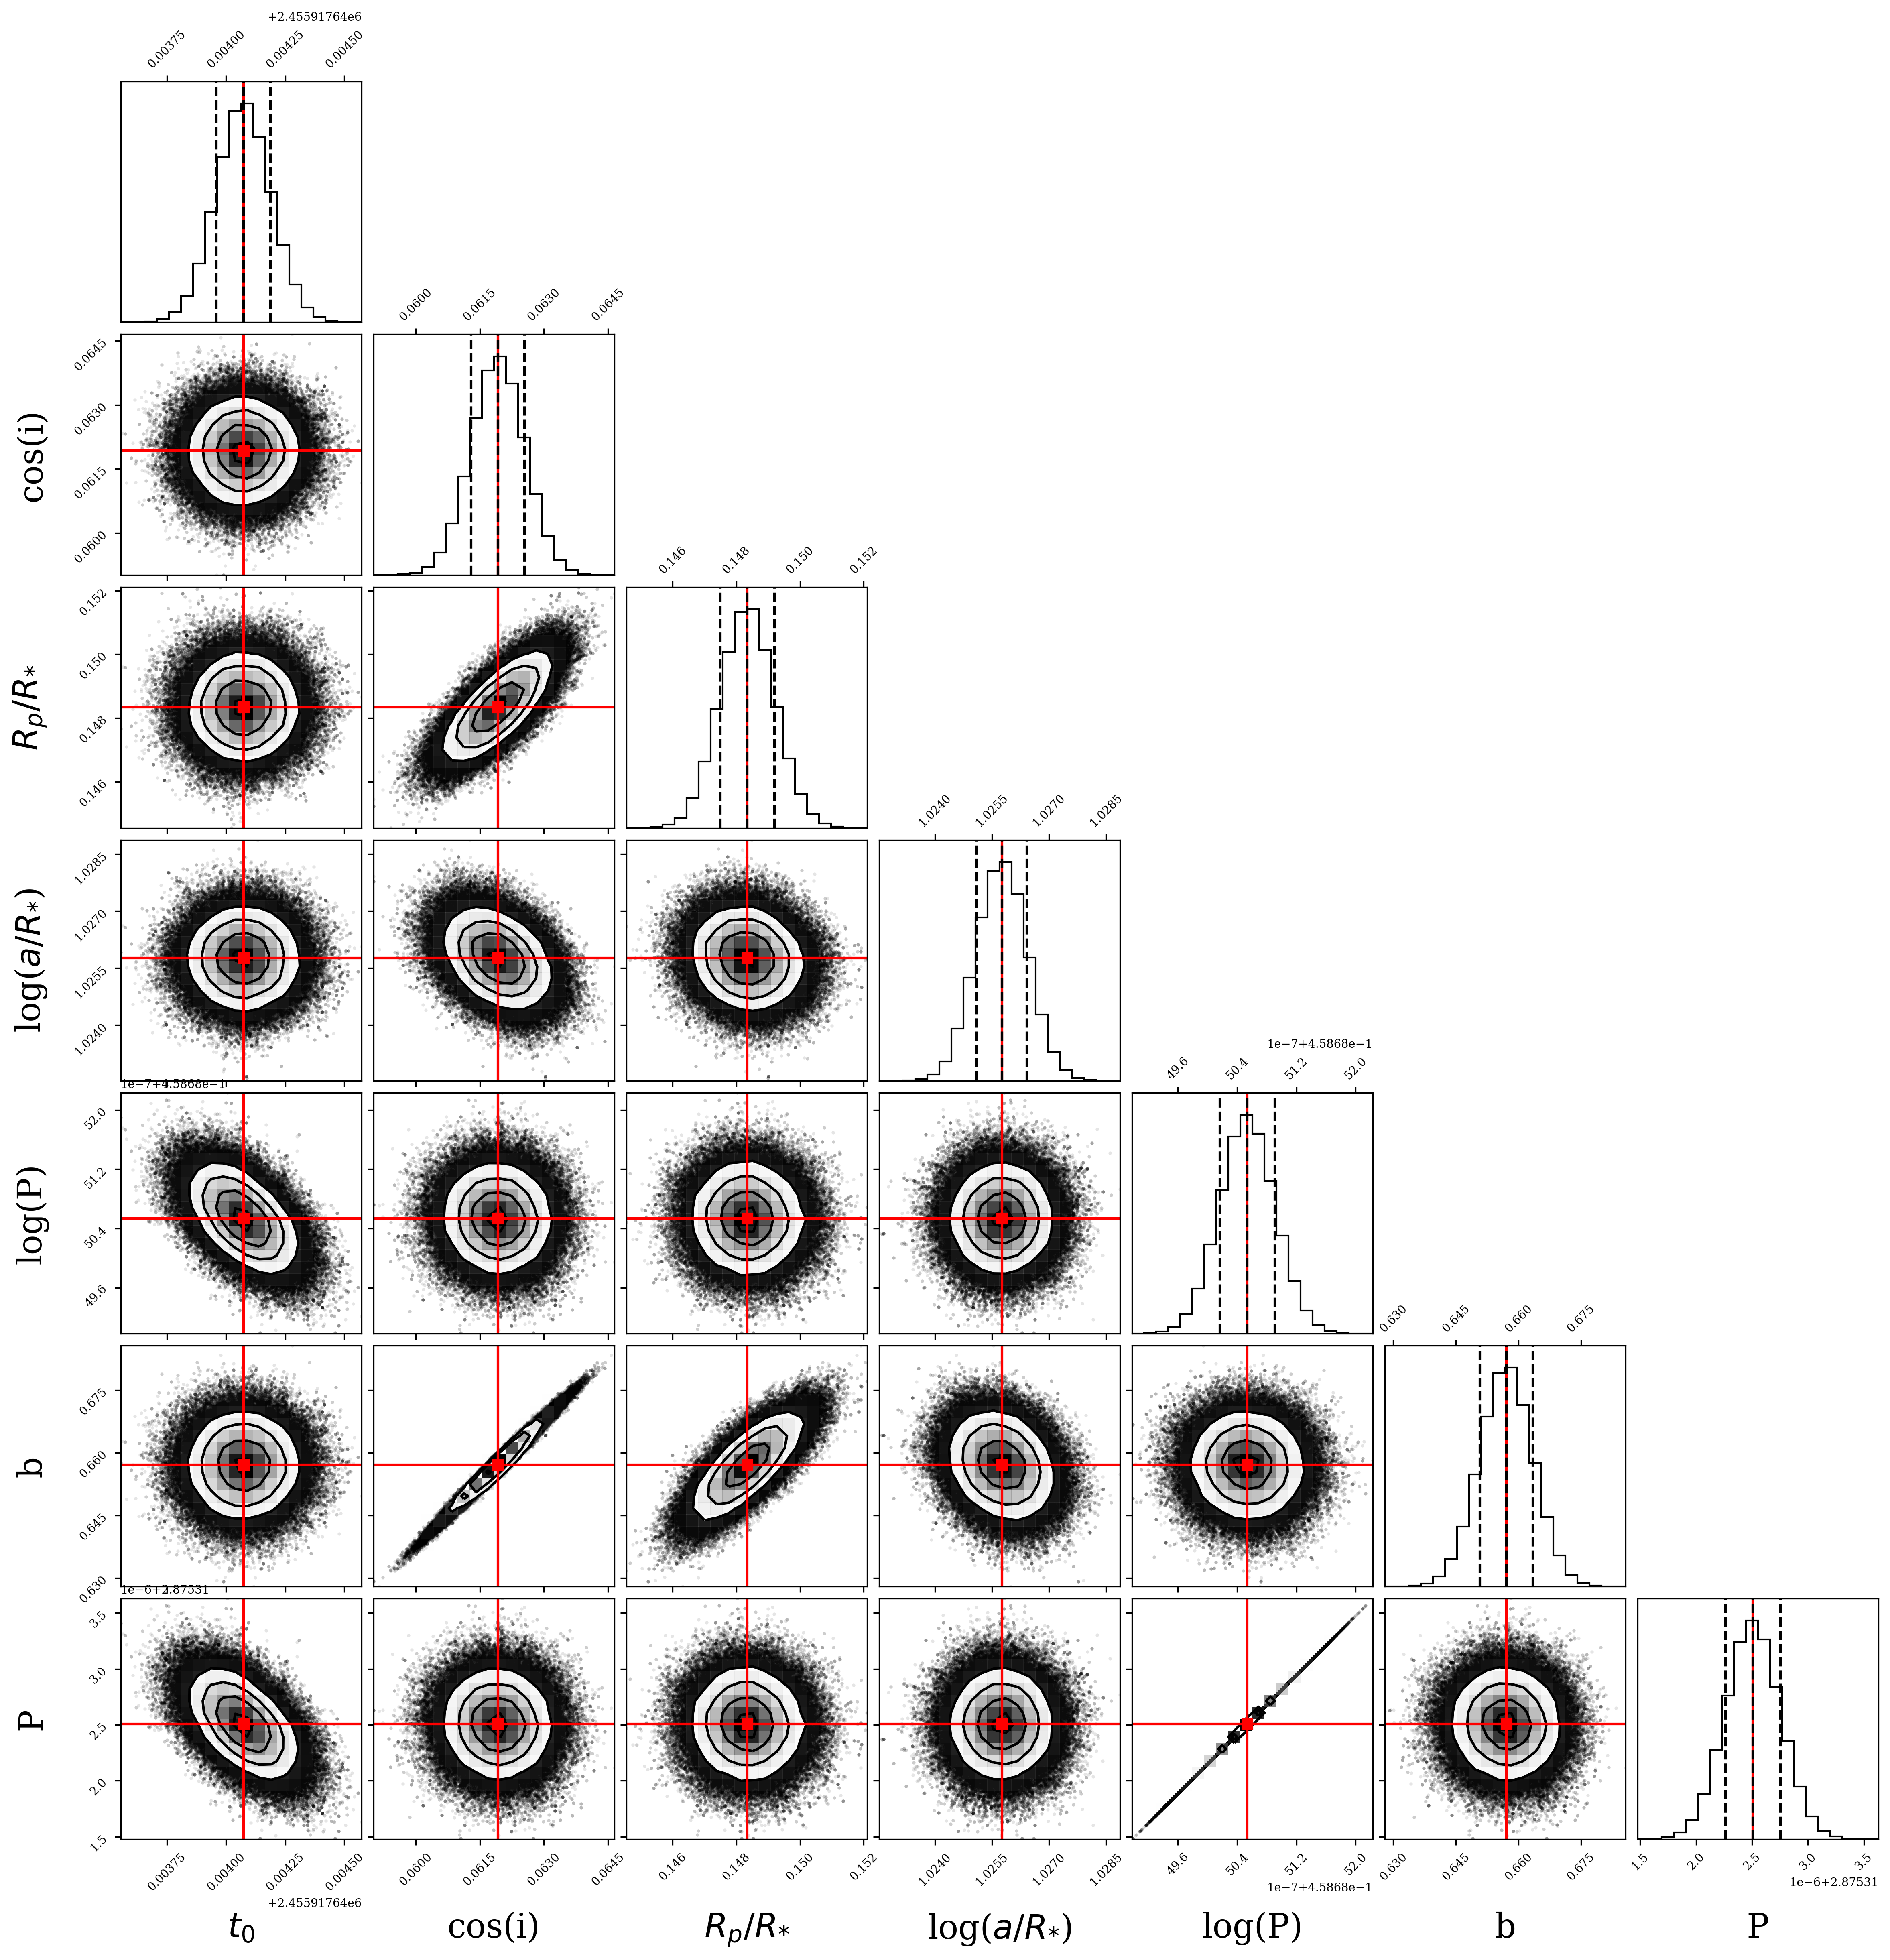

In [11]:
# Corner Plot
figure = corner.corner(flatchain, 
                       labels = ['$t_0$','cos(i)','$R_{p}/R_{*}$','log($a/R_{*}$)','log(P)','b','P'],
                       label_kwargs=dict(fontsize=20), 
                       truths=[pars_fit[0], pars_fit[1], pars_fit[2], pars_fit[3], pars_fit[4], pars_fit[5], pars_fit[6]], 
                       truth_color='#ff0000', quantiles=[0.16, 0.5, 0.84], 
                       top_ticks=True, 
                       verbose=False)
plt.savefig(f"final/HAT-P-20b_AllCorner.png")
plt.show()

# TRANSIT LIGHT CURVE PLOTS

In [12]:
# Required Arrays 
model_flux_time = transitmodel(pars_fit,time)
fres = flux - model_flux_time
time_init = (time-(pars_fit[0]-((10**pars_fit[4])/4)))/(10**pars_fit[4]) 
phase = np.mod(time_init,1)
model_phase = np.linspace(-0.25,0.75,2000)
model_times = (model_phase*(10**pars_fit[4])) + pars_fit[0]
model_flux_times = transitmodel(pars_fit, model_times)

# Binning
nbins = 35
binarr = binned_statistic(time, flux, statistic='median', bins=nbins)
binned_flux = binarr[0]
binarr = binned_statistic(time, time, statistic='median', bins=nbins)
binned_time = binarr[0]
binarr = binned_statistic(time, flux_err, statistic='mean', bins=nbins)
errtemp = binarr[0]
binarr = binned_statistic(time, flux_err, statistic='count', bins=nbins)
binned_flux_err = errtemp/np.sqrt(binarr[0])
binarr = binned_statistic(time, fres, statistic='median', bins=nbins)
binned_fres = binarr[0]

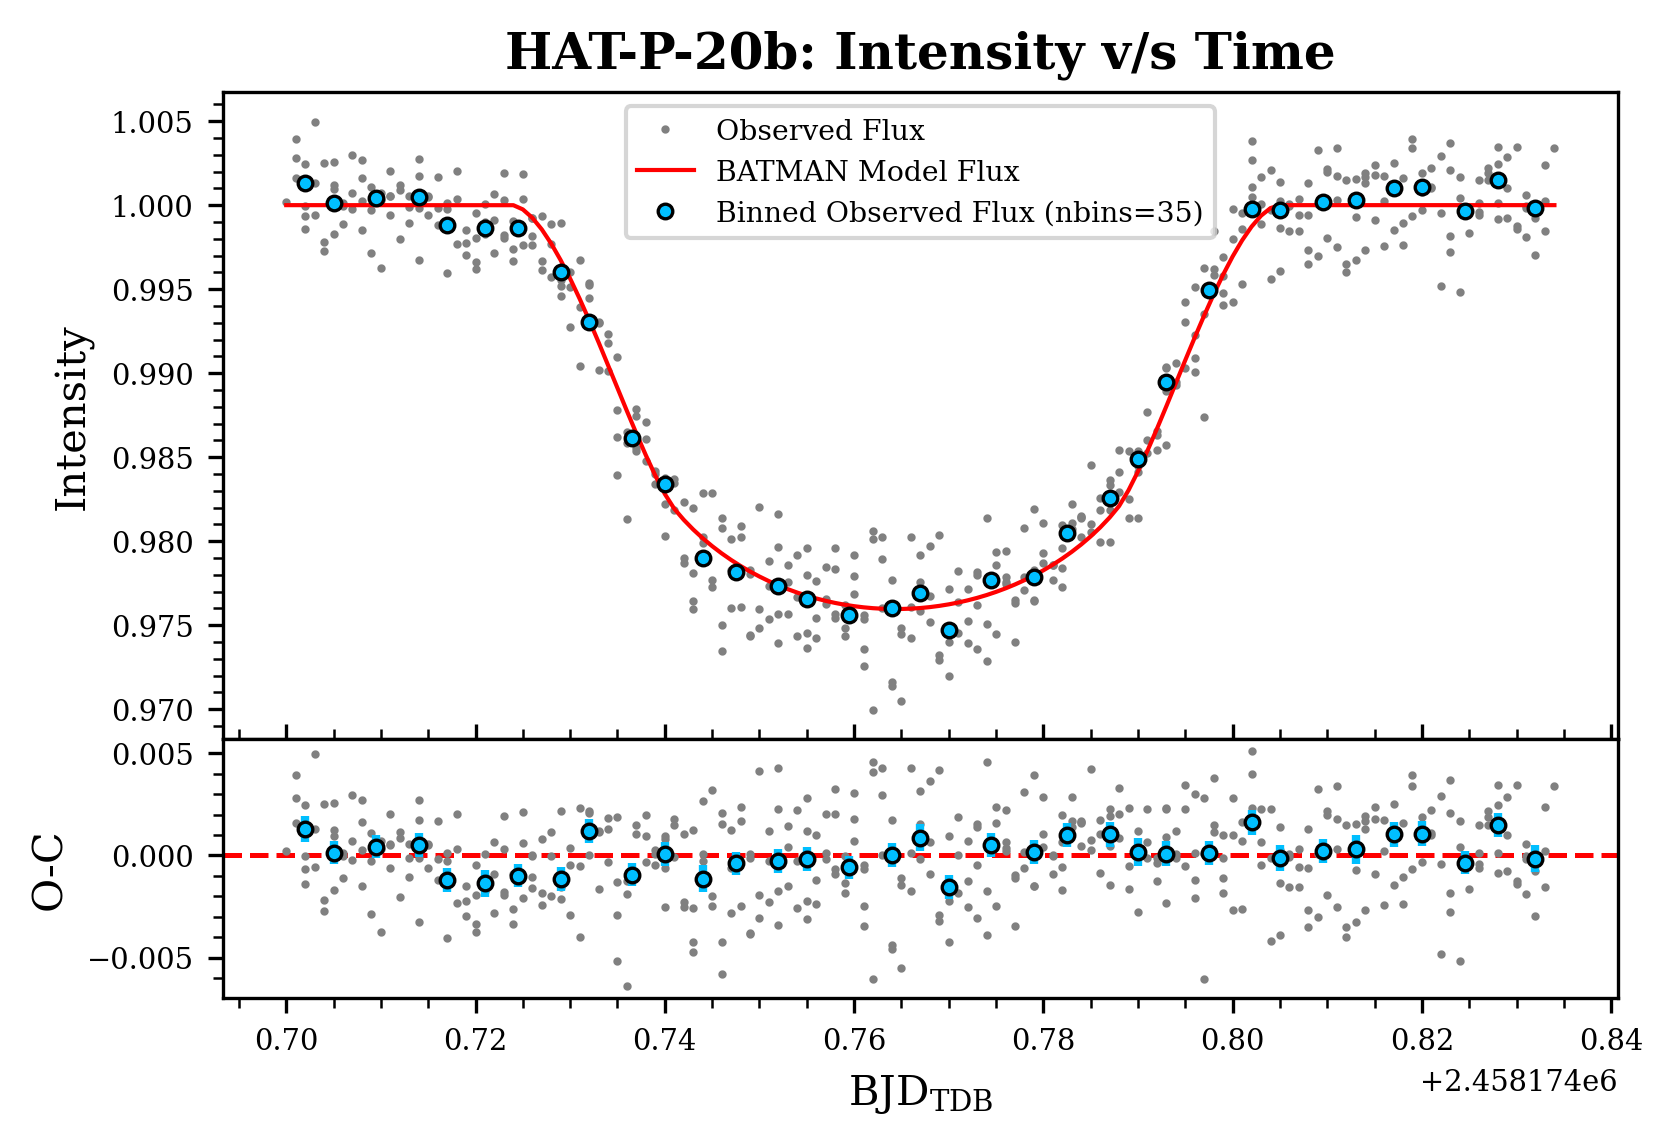

In [13]:
# Intensity v/s Time
f, a = plt.subplots(nrows=2, ncols=1, sharex='col', sharey=False, gridspec_kw={'height_ratios': [2, 0.8]})         
f.subplots_adjust(hspace=0)
a[0].set_title(f'HAT-P-20b: Intensity v/s Time', fontweight='bold')
a[0].plot(time, flux, ls='None', marker='.', ms=2, color='grey', zorder=0,label="Observed Flux")
a[0].plot(time, model_flux_time, 'r', alpha=1, lw=1, zorder=1, label="BATMAN Model Flux")
a[0].plot(binned_time, binned_flux, ls='None', marker='o', ms=3.5, markeredgecolor='black', markeredgewidth=0.8, zorder=3, color='deepskyblue', label=f"Binned Observed Flux (nbins={nbins})")
a[0].set_ylabel('Intensity')
a[0].tick_params(axis="x", which='both', direction="in")
a[0].legend(loc='best', prop={'size': 6.8})
#a[0].legend(bbox_to_anchor=(1,1))
a[1].plot(time, fres, ls='None', marker='.', ms=2, zorder=1, color='grey') #ecolor='g', elinewidth=0.4)
a[1].errorbar(binned_time, binned_fres, yerr=binned_flux_err, ls='None', marker='o', ms=3.5, markeredgecolor='black', markeredgewidth=0.8, zorder=2, color='deepskyblue', ecolor='deepskyblue', elinewidth=2)
a[1].set_ylabel('O-C')
#a[1].set_ylim(-0.002, 0.002)
a[1].axhline(0, linestyle='--', color="red", lw=1.2, zorder=0)
a[1].set_xlabel(r'BJD$\mathregular{_{TDB}}$')
for ax in a.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', length=2.5, color='k')
plt.savefig(f"final/HAT-P-20b_UnphasedIntensity.png")
plt.show()

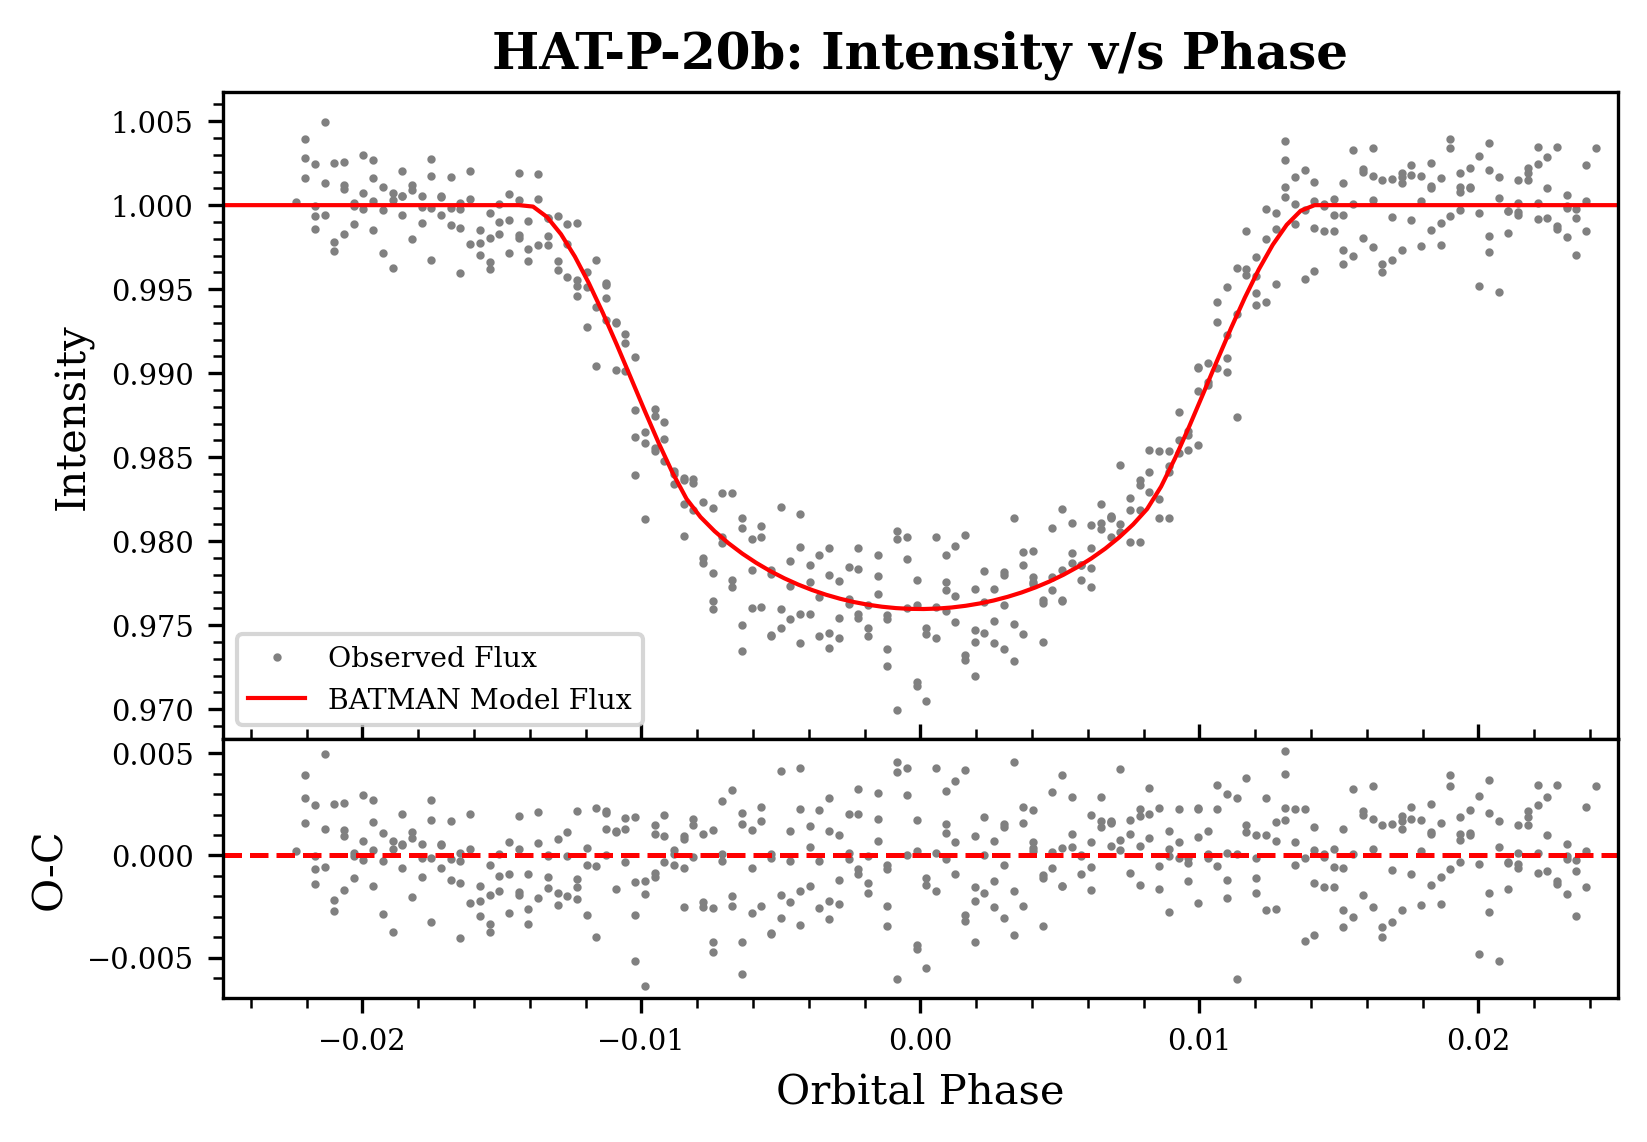

In [14]:
# Intensity v/s Phase
f, a = plt.subplots(nrows=2, ncols=1, sharex='col', sharey=False, gridspec_kw={'height_ratios': [2, 0.8]})         
f.subplots_adjust(hspace=0)
a[0].set_title(f'HAT-P-20b: Intensity v/s Phase', fontweight='bold')
a[0].plot(phase-0.25, flux, ls='None', marker='.', ms=2, zorder=0, color='grey', label="Observed Flux")
#a[0].plot(binned_phase-0.25, binned_detrended_norm_flux, ls='None', marker='o', ms=3.5, markeredgecolor='black', markeredgewidth=0.8, zorder=3, color='deepskyblue', label=f"Binned Detrended TESS Flux (nbins={nbins})")
a[0].plot(model_phase, model_flux_times,'r-', lw=1, zorder=1, label='BATMAN Model Flux')
a[0].set_ylabel('Intensity')
a[0].tick_params(axis="x", which='both', direction="in")
a[0].legend(loc='best', prop={'size': 6.8})
#a[0].legend(bbox_to_anchor=(1,1))
a[1].plot(phase-0.25, fres, ls='None', marker='.', ms=2, zorder=0, color='grey')
#a[1].errorbar(binned_phase-0.25, binned_rms_res, yerr=binned_norm_flux_err, ls='None', marker='o', ms=3.5, markeredgecolor='black', markeredgewidth=0.8, zorder=2, color='deepskyblue', ecolor='deepskyblue', elinewidth=2)
a[1].set_ylabel('O-C')
#a[1].set_ylim(-0.00135, 0.00135)
a[1].axhline(0, linestyle='--', color="red", lw=1.2, zorder=1)
a[1].set_xlabel(r'Orbital Phase')
for ax in a.flat:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='minor', length=2.5, color='k')
    ax.set_xlim(-0.025,0.025)
plt.savefig(f"final/HAT-P-20b_PhasedIntensity.png")
plt.show()

In [15]:
# Tests

## Test Standard Dev.
std_fres = np.std(fres)
avg_uncertainty = np.mean(flux_err)
diff = np.abs(avg_uncertainty - std_fres)
print(f"""STANDARD DEVIATION TEST: 
Standard Deviation of RMS Residuals = {std_fres}
Observed Flux Mean = {avg_uncertainty}""")
if std_fres > avg_uncertainty:
    print(f"Standard Deviation of RMS Residuals > Observed Flux Mean by {diff}")
if std_fres == avg_uncertainty:
    print(f"Standard Deviation of RMS Residuals = Observed Flux Mean by {diff}")
if std_fres < avg_uncertainty:
    print(f"Standard Deviation of RMS Residuals < Observed Flux Mean by {diff}")
    
## Anderson-Darling Test
a = anderson(fres)
print(f"""ANDERSON-DARLING TEST:
{a}""")

## KS Test
ks = kstest(fres,'norm')
print(f"""KOLMOGOROV-SMIRNOV TEST:
{ks}""")

STANDARD DEVIATION TEST: 
Standard Deviation of RMS Residuals = 0.002150673141312315
Observed Flux Mean = 0.002140319067709174
Standard Deviation of RMS Residuals > Observed Flux Mean by 1.0354073603140689e-05
ANDERSON-DARLING TEST:
AndersonResult(statistic=0.7407211747827205, critical_values=array([0.571, 0.65 , 0.78 , 0.91 , 1.082]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
KOLMOGOROV-SMIRNOV TEST:
KstestResult(statistic=0.4979600827902224, pvalue=9.919375455469025e-103)


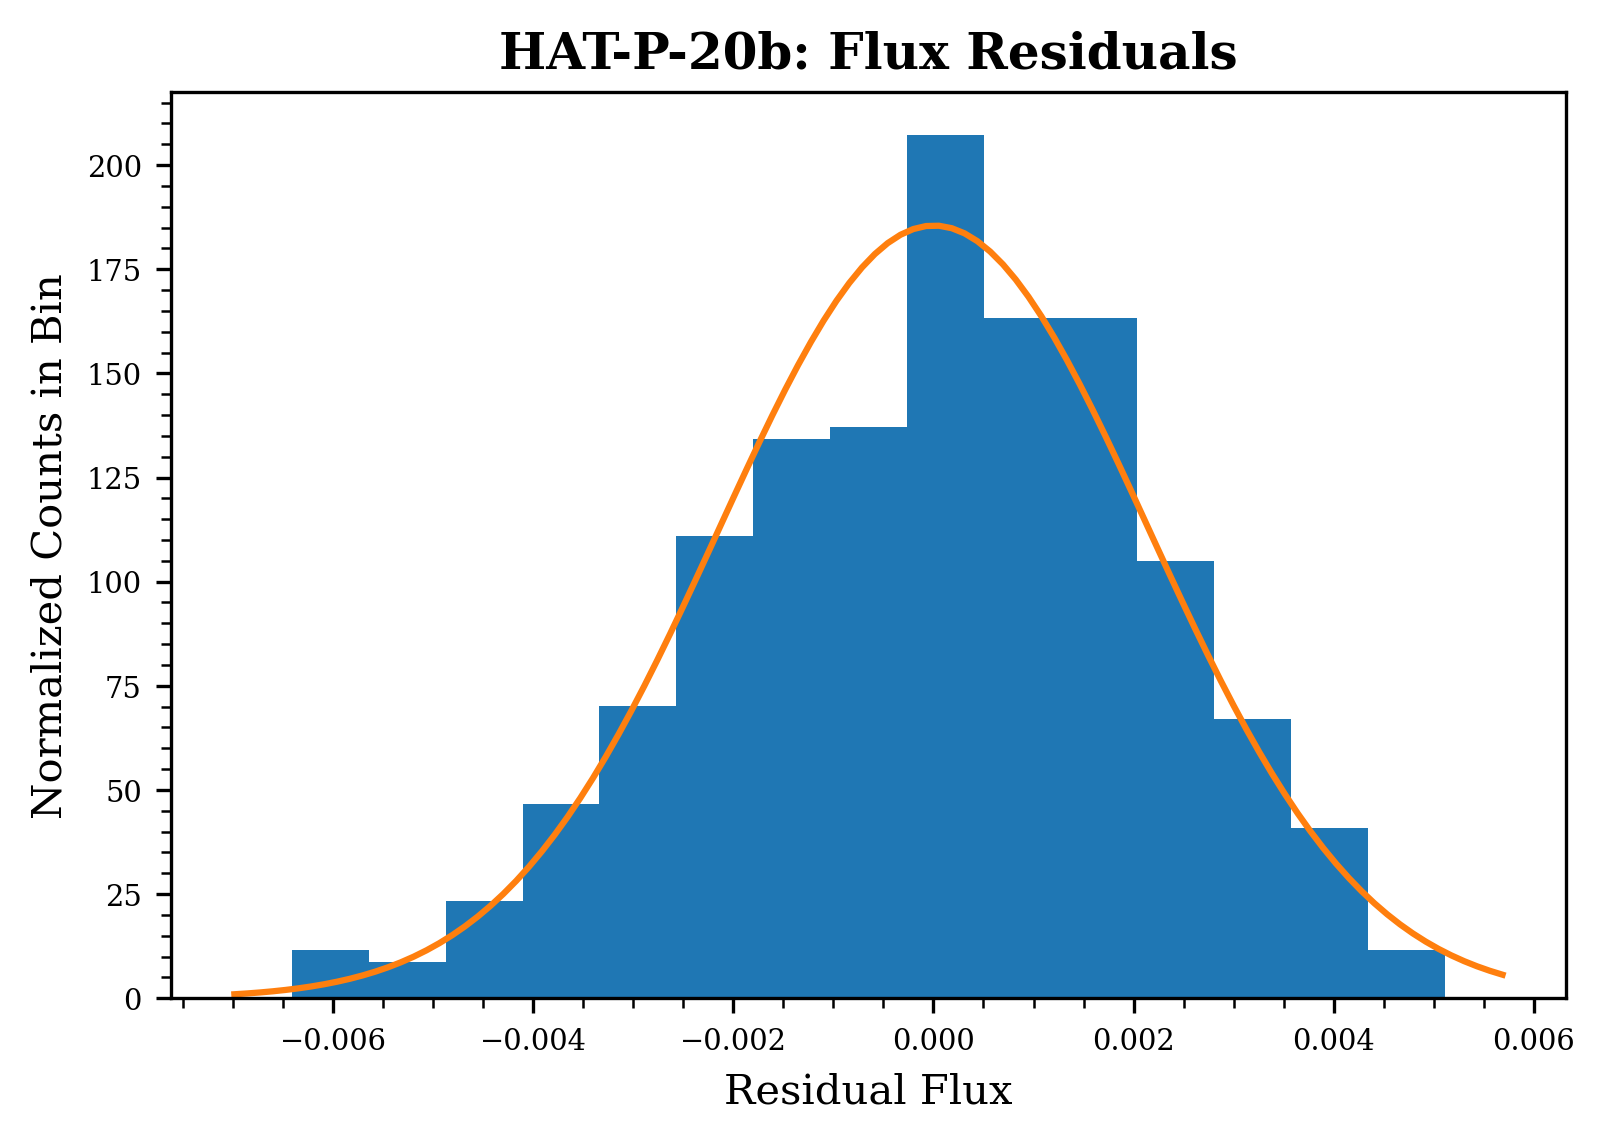

In [16]:
# Flux Residuals Distribution Plot
f,a = plt.subplots()
mean,std=norm.fit(fres)
a.hist(fres, bins='auto', density = True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
a.plot(x, y)
a.set_xlabel('Residual Flux')
a.set_ylabel('Normalized Counts in Bin') 
plt.title(f'HAT-P-20b: Flux Residuals', fontweight='bold')
a.xaxis.set_minor_locator(AutoMinorLocator())
a.yaxis.set_minor_locator(AutoMinorLocator())
a.tick_params(which='minor', length=2.5, color='k')
plt.savefig(f"final/HAT-P-20b_FluxResiduals.png")